### This notebook does the following
#### -- It generates a sky spectrum in Temperature vs frequency units over 2-4 GHz assuming a power law model of the sky
#### -- It assumes a sine^theta beam
#### -- It uses 3 input maps that are pre-prepared at spot frequencies and 5 deg resolution (3072 pixels in Healpix format
#### -- It uses an intensity vs frequency file for the CRR prediction 
#### -- Mimics for N spectra (vs time) the sky spectrum at a specific location and UTC -- with or without the CRR lines included
#### -- Calibration from intensity to temperature units assuming RJ correction, CMB temperature etc are all included

#### Pre requisite packages and files to run this notebook
#### healpy, numpy, matplotlib, math, astropy, ephem, pandas, scipy, os
#### total_new_spec.txt, map_408_r4_5deg_nested_galactic_Kelvin.txt, map_1420_r4_5deg_nested_galactic_Kelvin.txt, map_23000_r4_5deg_nested_galactic_Kelvin.txt

In [22]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import os

%matplotlib inline

import ephem
from astropy.time import Time
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u
from astropy.timeseries import TimeSeries, BinnedTimeSeries
from astropy.time import Time, TimeDelta

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline

### Place the path to all the input and output files in your local machine

In [4]:
file_input_path = '/home/msrao/Workspace/L1_RRIDistortionLab/L2_APSERa/L3_APSERa_data/apsera_spectra_simulations'
file_output_path = '/home/msrao/Workspace/L1_RRIDistortionLab/L2_APSERa/L3_APSERa_data/apsera_spectra_simulations'

### Define necessary constants and corrections (if any)

In [24]:
## correction_150offset = 21.4; // Kelvin, Patra et al. 2015
## correction_150scaling = 1.05; // Patra et al. 2015
TCMB = 2.72548 # Kelvin
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08

### Define instrument / experiment parameters

In [25]:
f_start = 2  # GHz              
f_stop = 4  #GHz
f_res = 0.001   # GHz 
N_SIDE = 16                   #Healpy parameter: resolution of the map is defined by the NSIDE parameter, which is generally a power of 2.
T_hot = 300
T_cold = 77                    #T_cold and T_hot in Kelvins (for atmospheric corrections to calculate noise added) purposefully taken to be a few thousands
Time_in_UTC = ts
latitude = 13.067439
longitude =80.237617            #Latitude and longitude in degrees
altitude = 0                     #Altitude in meters
alpha = 0.0065                   #Temp. lapse rate (deg C per meter); related to atmospheric corrections
PI = 3.14159265
Noise_int_time = 3e+13
Trx = 30                        # Receiver temperature in Kelvin
T_atm = 1                       # Noise temp added by atmosphere 
freq = np.arange(f_start, f_stop, f_res)
No_of_Channels = np.size(freq)
#create arrays 
CMB_Int = np.empty([No_of_Channels])
P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)


#sky temperature in real and noise temperature stored in imaginary part
cross_real = [0]*No_of_Channels
cross_imag = [0]*No_of_Channels
sumwt = [0]*No_of_Channels
sigma = [0]*No_of_Channels     #noise per channel
spectra = [0]*n_spectra
spectra_cross_imag = [0]*n_spectra
NPIX = hp.nside2npix(N_SIDE)
print("Number of pixels for NSIDE ",N_SIDE," is ",NPIX)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        N_SIDE, hp.nside2resol(N_SIDE, arcmin=True) / 60
    )
)


#Refraction correction formula
def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)
    return alt_in_deg +R

Obs = ephem.Observer()
#print(Obs)
t = Time(Time_in_UTC, scale='utc',location= EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m))
lst = t.sidereal_time('apparent')
print(lst)

#alt == theta angle; az == phi angle; both in degrees
def beam_def(freq, alt, az):
    if (alt<=0):
        return 0
    else:
        return (math.sin(alt*PI/180)*math.sin(alt*PI/180))


Number of pixels for NSIDE  16  is  3072
Approximate resolution at NSIDE 16 is 3.7 deg
[21h03m02.04439668s]


### Read input sky maps apply corrections

In [9]:
sky_408 = np.loadtxt(os.path.join(file_input_path, 'map_408_r4_5deg_nested_galactic_Kelvin.txt')) 
sky_1420 = np.loadtxt(os.path.join(file_input_path,'map_1420_r4_5deg_nested_galactic_Kelvin.txt'))
sky_23000 = np.loadtxt(os.path.join(file_input_path,'map_23000_r4_5deg_nested_galactic_Kelvin.txt'))

sky_408 = sky_408-TCMB
sky_1420 = sky_1420 - TCMB
print("Got 408MHz, 1420MHz and 23000MHz maps for power law fitting, and applied necessary corrections!")

Got 408MHz, 1420MHz and 23000MHz maps for power law fitting, and applied necessary corrections!


### Generate the sky model -- save the model to a file in the file_output_path.
#### The cell below is an example of how the fitting is done for the 0th index pixel of the input sky map files. This doesn't generate the model for the full sky, uncomment only to see what the model does / fit looks like for a pixel. Actual sky model generation is in the cell below that runs this for all 3072 pixels

In [15]:
# def fit_power_law(x_vals, y_vals, plot=True):
#     """
#     Fit y = A * x^m to points in log-log space and optionally plot the fit.

#     Parameters:
#         x_vals (array-like): x values
#         y_vals (array-like): y values
#         plot (bool): whether to show the plot

#     Returns:
#         m: slope (power exponent)
#         c: intercept in log-log space
#         A: coefficient in y = A * x^m
#     """
#     x_vals = np.array(x_vals, dtype=float)
#     y_vals = np.array(y_vals, dtype=float)

#     # Take logs
#     log_x = np.log(x_vals)
#     log_y = np.log(y_vals)

#     # Fit a straight line
#     m, c = np.polyfit(log_x, log_y, 1)
#     A = np.exp(c)

#     if plot:
#         # Generate smooth line for plotting
#         x_fit = np.linspace(min(x_vals), max(x_vals), 100)
#         y_fit = A * x_fit**m

#         plt.figure(figsize=(6, 5))
#         plt.scatter(x_vals, y_vals, color='red', label='Data Points')
#         plt.plot(x_fit, y_fit, color='blue', label=f'Fit: y = {A:.3f} x^{m:.3f}')

#         plt.xscale('log')
#         plt.yscale('log')
#         plt.xlabel('x')
#         plt.ylabel('y')
#         plt.title('Power-Law Fit in Log-Log Space')
#         plt.legend()
#         plt.grid(True, which="both", ls="--", linewidth=0.5)
#         plt.show()

#     return m, c, A

# # Example with 3 points
# x_data = [0.408, 1.420, 23]
# y_data = [sky_408[0],sky_1420[0],sky_23000[0]]

# m, c, A = fit_power_law(x_data, y_data)

# print(f"Slope (m): {m:.4f}")
# print(f"Intercept in log-log space (c): {c:.4f}")
# print(f"Coefficient A: {A:.4f}")
# print(f"Fitted equation: y = {A:.4f} * x^{m:.4f}")


##### Note this can be done one time and the cell below can be skipped if you have already generated this power law sky model
##### Output file name is power_law_model_loglog.txt

In [18]:
# #  3 x-values are fixed for all fits
# x_vals = np.array([0.408, 1.420, 23])

# # Three arrays of y-values for each x
# y1 = sky_408
# y2 = sky_1420
# y3 = sky_23000

# # Stack them so each row corresponds to one fit
# Y = np.column_stack([y1, y2, y3])  # shape: (n_points, 3)
# power_law_model = os.path.join(file_input_path,"power_law_model_loglog.txt")
# # Open output file
# with open(power_law_model, "w") as f:
#     f.write("Index\tSlope(m)\tIntercept(c)\tCoefficient(A)\n")
    
#     # Loop through each row of Y
#     for i in range(Y.shape[0]):
#         y_vals = Y[i, :]
        
#         # Log transform
#         log_x = np.log(x_vals)
#         log_y = np.log(y_vals)
        
#         # Fit line in log-log space
#         m, c = np.polyfit(log_x, log_y, 1)
#         A = np.exp(c)
        
#         # Save to file
#         f.write(f"{i}\t{m:.6f}\t{c:.6f}\t{A:.6f}\n")

# print("✅ Done! Results saved to 'power_law_model_loglog.txt'")


✅ Done! Results saved to 'power_law_model_loglog.txt'


### The cell below uses the computed power law fit coefficients and generates the T_sky at every pixel over 2-4 GHz with 1 MHz resolution
### Saves the output to a file called powerlaw_sky_2_4_GHz_1MHz_res_3072pixels.txt
### This cell can also be run one time and not generated every single time we run the notebook, comment out after running once for saving time!

In [19]:
# # Read the sky model
# sky_model = os.path.join(file_input_path,"power_law_model_loglog.txt")

# # New x-values for prediction
# x_new = np.arange(2,4,0.001)

# # Load the saved model parameters
# df = pd.read_csv(sky_model, sep="\t")

# # Create a DataFrame to store predictions
# pred_df = pd.DataFrame(columns=["Index"] + [f"x={v}" for v in x_new])

# for _, row in df.iterrows():
#     idx = int(row["Index"])
#     m = row["Slope(m)"]
#     A = row["Coefficient(A)"]

#     y_pred = A * (x_new ** m)

#     # Append to DataFrame
#     pred_df.loc[len(pred_df)] = [idx] + list(y_pred)
# output_sky_2_4_GHz = os.path.join(file_output_path,"powerlaw_sky_2_4_GHz_1MHz_res_3072pixels.txt")
# # Save to text file with tab separation
# pred_df.to_csv(output_sky_2_4_GHz, sep="\t", index=False)

# print("Computed sky model saved to powerlaw_sky_2_4_GHz_1MHz_res_3072pixels.txt")


Computed sky model saved to powerlaw_sky_2_4_GHz_1MHz_res_3072pixels.txt


### If your experiment frequency range is different from 2-4 GHz or different freq resolution wihtin 2-4 GHz as defined in the instrument parameters defined in a previous cell, run the sky model fresh below, i.e. when you cannot use a precalculated 2-4 GHz, 0.001 GHz resolution sky 

In [20]:
# ### Estimate the sky spectrum at each pixel with the power law model for the frequency range defined above

# sky_model = os.path.join(file_input_path,"power_law_model_loglog.txt")

# # New x-values for prediction
# x_new = freq

# # Load the saved model parameters
# df = pd.read_csv(sky_model, sep="\t")

# # Create a DataFrame to store predictions
# pred_df = pd.DataFrame(columns=["Index"] + [f"x={v}" for v in x_new])

# for _, row in df.iterrows():
#     idx = int(row["Index"])
#     m = row["Slope(m)"]
#     A = row["Coefficient(A)"]

#     y_pred = A * (x_new ** m)

#     # Append to DataFrame
#     pred_df.loc[len(pred_df)] = [idx] + list(y_pred)

In [26]:
start_time_in_UTC = '2024-01-01 09:00:00'
n_spectra = 1                  #Number of spectra to be taken
delta_t_in_hours = 1/60            #Time interval between each spectra needed in hours

t = Time(start_time_in_UTC, format = 'iso', scale= 'utc')

ts = TimeSeries(time_start= start_time_in_UTC, time_delta= delta_t_in_hours *u.hour, n_samples= n_spectra)
ts = ts.time
print(ts)

['2024-01-01 09:00:00.000']


In [28]:
#P_hot and P_cold for calibration
P_hot = (2*h*freq*1e9)/(np.exp((h*freq*1e9)/(k*T_hot))-1)
P_cold = (2*h*freq*1e9)/(np.exp((h*freq*1e9)/(k*T_cold))-1)
P_dif = P_hot -P_cold
#print(P_hot)
print("Got P_dif for calibration!")

Got P_dif for calibration!


In [30]:
recomb_file = os.path.join(file_input_path,'total_spec_new.txt')
df = pd.read_csv(recomb_file,sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]
x = df["Frequency"]
y= df["Intensity"]
ius = InterpolatedUnivariateSpline(x, y)   #1-D interpolating spline for a given set of data points; default k=3 being cubic spline
crr_int = ius(freq)

/tmp/ipykernel_779240/546507951.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(recomb_file,sep= "    " ,header = None)


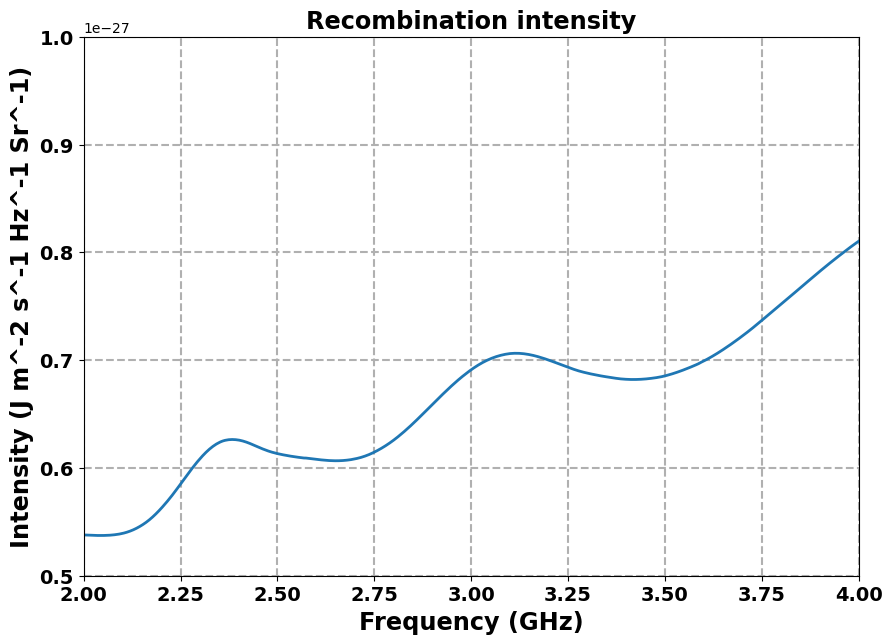

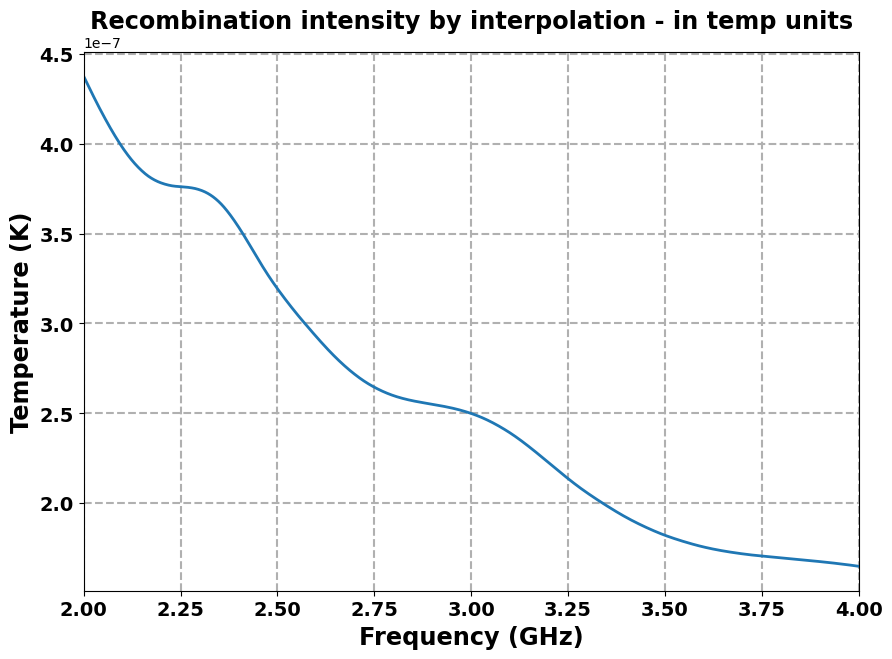

In [35]:
plt.figure(figsize=(10, 7))
#plt.plot((df['Frequency']), (df['Intensity']),linewidth=2)
plt.plot(x, y,linewidth=2)
plt.title('Recombination intensity', fontsize='xx-large', fontweight='bold')
plt.xlabel('Frequency (GHz)', fontsize='xx-large', fontweight='bold')
plt.ylabel('Intensity (J m^-2 s^-1 Hz^-1 Sr^-1)', fontsize='xx-large', fontweight='bold')
plt.xlim([f_start,f_stop])
plt.ylim([0.5e-27,1e-27])
plt.xticks(fontsize = 14, fontweight='bold')
plt.yticks(fontsize = 14, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()


#In terms of temperature
temp_recom=((c**2)*crr_int)/(2*k*(freq**2)*1e18)
plt.figure(figsize=(10, 7))
plt.title('Recombination intensity by interpolation - in temp units', fontsize='xx-large', fontweight='bold')
plt.plot(freq, temp_recom,linewidth=2)
plt.xlabel('Frequency (GHz)', fontsize='xx-large', fontweight='bold')
plt.ylabel('Temperature (K)', fontsize='xx-large', fontweight='bold')
plt.xlim([f_start,f_stop])
# plt.ylim([0.5e-27,1e-27])
plt.xticks(fontsize = 14, fontweight='bold')
plt.yticks(fontsize = 14, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

### Put everything together to get sky spectra!

In [36]:
sky_2_4_GHz = os.path.join(file_output_path,"powerlaw_sky_2_4_GHz_1MHz_res_3072pixels.txt")
df_sky = pd.read_csv(sky_2_4_GHz, sep="\t")
## or
## df_sky = pred_df

print(df_sky)  # Just to check what it looks like
arr = df_sky.drop(columns=["Index"]).to_numpy()
np.shape(arr)

       Index     x=2.0   x=2.001   x=2.002  x=2.0029999999999997  \
0        0.0  2.230426  2.227654  2.224886              2.222123   
1        1.0  1.365733  1.363953  1.362176              1.360403   
2        2.0  1.632749  1.630619  1.628494              1.626372   
3        3.0  1.054613  1.053184  1.051757              1.050334   
4        4.0  0.905926  0.904710  0.903496              0.902284   
...      ...       ...       ...       ...                   ...   
3067  3067.0  0.856412  0.855297  0.854184              0.853073   
3068  3068.0  0.888244  0.887081  0.885920              0.884761   
3069  3069.0  1.485935  1.484084  1.482237              1.480394   
3070  3070.0  1.438319  1.436522  1.434727              1.432936   
3071  3071.0  2.391046  2.388190  2.385339              2.382493   

      x=2.0039999999999996  x=2.0049999999999994  x=2.0059999999999993  \
0                 2.219365              2.216611              2.213863   
1                 1.358632         

(3072, 2000)

In [40]:
pixel_indices = np.arange(0,3072)
coords = hp.pixelfunc.pix2ang(16, pixel_indices , nest = True, lonlat = True)          #pix2ang = gives l and b coordinates for each pixel; NSIDE=16 
gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic') 
print(np.shape(coords))
print(np.shape(gc))

(2, 3072)
(3072,)


In [ ]:
t = 0
while t<n_spectra:
    i=1
    while i<NPIX:           #Working on each pixel
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc[i].transform_to(AltAz(obstime = Time_in_UTC[t], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
        

        #print(freqs)
        j=0
        longitudes = equi.az.value
        while j< No_of_Channels:
            if (longitudes>359.00):
                longitudes = 359.00
            cwt = beam_def(freqs[j], new_alt, longitudes)   #beam weight
            #print(new_alt,cwt)
            if (cwt>0):     #Adding all the three intensities

                map_1 = (2*k*1e+18 * (freqs[j]**2) *sky_408[i-1]* np.power(freqs[j]/0.408, float(popt)))/ (c**2)
                Power = (map_1 + CMB_Int[j]+Rec_int[j]) *(c*c/ (1e+18* freqs[j]**2)) #+Rec_int[j]
                final_temp = (Power/P_dif[j])*(T_hot-T_cold)   #calibrated power using Tcold and Thot
                
                cross_real[j] = cross_real[j] + cwt*final_temp#* (1 - np.power(gamma_func(freqs[j]),2))
                
                ## Remove the (1 - np.power(gamma_func(freqs[j]),2)) to try for ideal antenna (no return loss)
                
                sumwt[j] = sumwt[j]+ cwt   #sumwt has cumulative beam weigths
            
            j = j+1
            
        if (i%1000 == 0):
            print('Number of pixels got: ', i)
        
        i = i+1

    
    i=0    #index i for below loop is channel number
    while(i< No_of_Channels):
        if sumwt[i]>0:
            cross_real[i] = cross_real[i]/sumwt[i]
        i = i+1
        
    
    sigma = (np.array(cross_real) + Trx+ T_atm)/ math.sqrt(Channel_width*1e9*Noise_int_time)    #radiometer equation
    
    #Generating an array of random integers with mean 0 and std 1. 
    array = np.random.normal(0,1,No_of_Channels)

    #Adding the gaussian error
    
    cross_real = cross_real + array*sigma       #cross_real has Tsky
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions
                                                    
    cross_imag = cross_imag + array*sigma       #cross_imag has noise (to keep track of noise terms, which is also added to real part)
    
    spectra[t] = cross_real
    spectra_cross_imag[t] = cross_imag
    
    cross_real = [0]*No_of_Channels
    cross_imag = [0]*No_of_Channels
    sumwt = [0]*No_of_Channels
    sigma = [0]*No_of_Channels   #assigning all the above 4 parameters to zero valued arrays
    
    print("No. of spectra got = ", t+1)
    
    t = t+1

###end of one timestamp

Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
lst = t.sidereal_time('apparent')
    

i=0
while(i<n_spectra):
    plt.plot(freqs, spectra[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s'%lst)
plt.grid()
plt.show()

plt.plot(freqs, spectra[0])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('One spectrum - Simulated Sky Spectrum at LST :%s'%lst[0])
plt.grid()
plt.show()